# 1. Import dependencies and data sets

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf

In [2]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
anyio                        4.0.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
array-record                 0.4.1
arrow                        1.3.0
asttokens                    2.4.0
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.16.0
charset-normalizer           3.3.0
click                        8.1.7
comm                         0.1.4
contourpy                    1.1.0
cycler                       0.12.0
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
dm-tree                      0.1.8
eti

In [3]:
hasGPUSupport = tf.test.is_built_with_cuda()
gpuList = tf.config.list_physical_devices('GPU')
print("Tensorflow Compiled with CUDA/GPU Support:", hasGPUSupport)
print("Tensorflow can access", len(gpuList), "GPU")
print("Accessible GPUs are:")
print(gpuList)

Tensorflow Compiled with CUDA/GPU Support: True
Tensorflow can access 0 GPU
Accessible GPUs are:
[]


In [4]:
for gpu in gpuList:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [6]:
#bringing in fashion mnist dataset
ds = tfds.load('fashion_mnist',split='train')

In [7]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

# 2. Visualizing Data Set

In [8]:
import numpy as np

In [9]:
#Setting up data iterator
data_iterator = ds.as_numpy_iterator()

In [10]:
#Getting data out of the pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

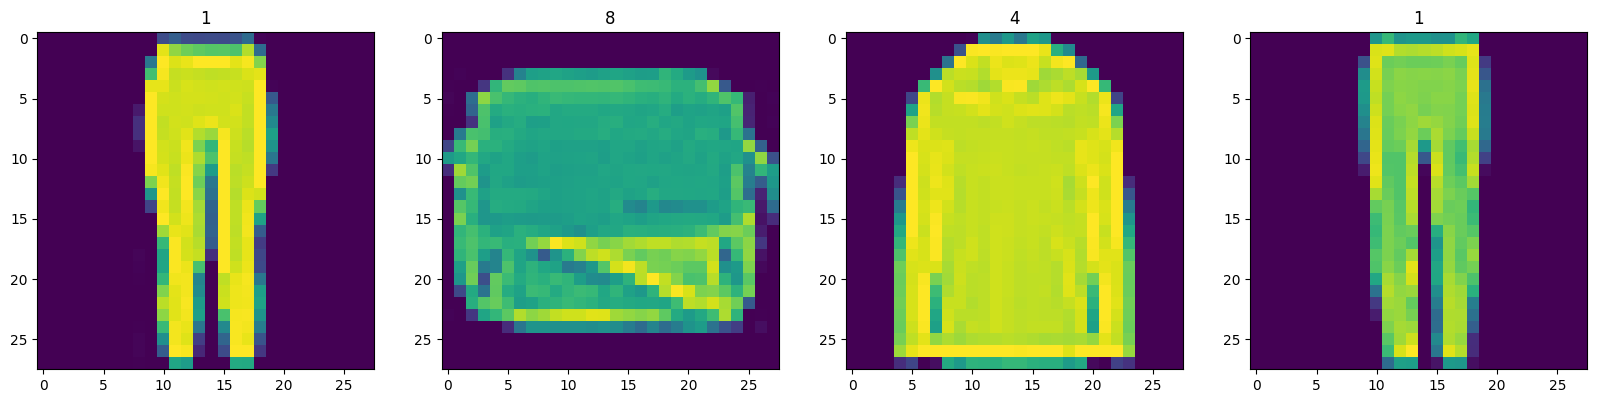

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [12]:
#Scale and return images only
def scale_images(data):
    image = data['image']
    return image/255

# 3. Preping the Dataset for Training

In [13]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [14]:
#Reload the dataset
ds = tfds.load('fashion_mnist',split='train')
#Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
#cache the dataset from that batch
ds = ds.cache()
#shuffle it up
ds = ds.shuffle(60000)
#batch into 128 images per sample
ds = ds.batch(128)
#Reduces the likelihood of bottle necking
ds = ds.prefetch(64)

# 4. Building the Neural Network

## 4.1. Building the Generator

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [16]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshape it to 7x7x128
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Up-sampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    # Up-sampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv Layer to get to one Channel
    model.add(Conv2D(1,4,padding='same', activation='sigmoid'))

    return model

In [17]:
test_model = build_generator()
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 25ms/step


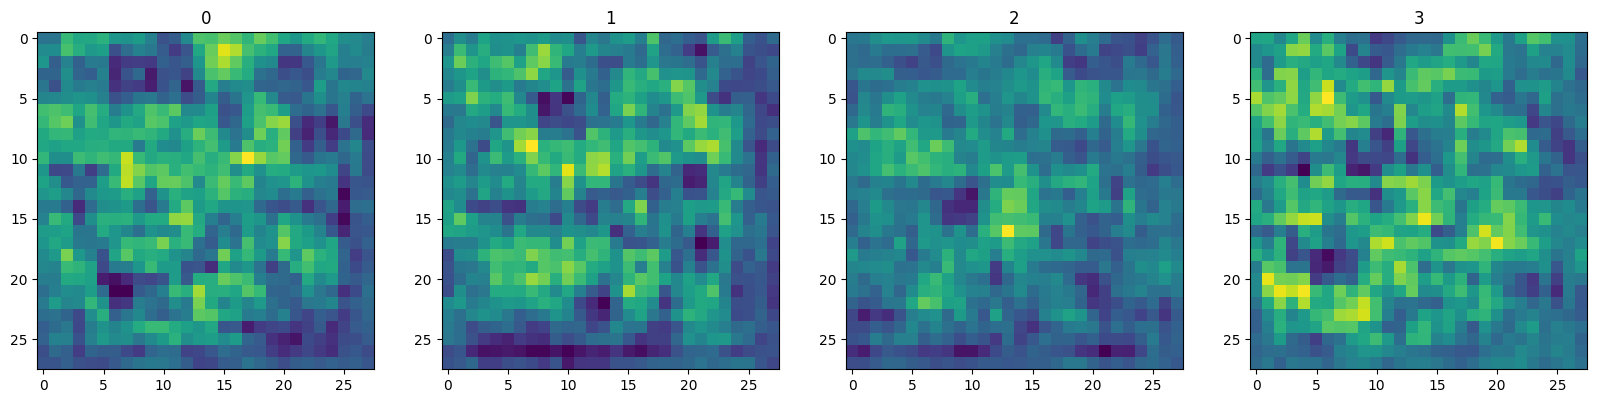

In [38]:
#testing the generator model by generating new random sampling
input_x = np.random.randn(4,128,1)
img = test_model.predict(input_x)
#visualizing the images generated
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img_ in enumerate(img):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(img_))
    ax[idx].title.set_text(idx)

## 4.2. Building the Discriminator

In [32]:
def build_discriminator():
    model = Sequential()
    
    #First Conv Block
    model.add(Conv2D(32,5,input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Second Conv Block
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Third Conv Block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Fourth Conv Block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4)) #questionable layer
    model.add(Dense(1,activation='sigmoid'))
    
    return model

In [33]:
discriminator = build_discriminator()

In [34]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      

In [39]:
img.shape

(4, 28, 28, 1)

In [40]:
discriminator.predict(img)

1/1 [==============================] - 0s 52ms/step


array([[0.49417907],
       [0.49433216],
       [0.49397665],
       [0.4941302 ]], dtype=float32)

# 5. Constructing Training Loop

## 5.1. Setup Losses and Optimizers

In [41]:
#optimizer and loss function for both generator and discriminator
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [42]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001) #It is better if the discriminator learning rate is lower than of the generator

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## 5.2. Setting up Subclassed Models

In [43]:
#Importing the base model class to subclass 
from keras.models import Model

In [ ]:
###### Do not Run This Sell
###### other way to write subclass functions (example)

@tf.function
def train_step():
    pass

In [44]:
class FashionGAN(Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        #pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        
        #creating attributes
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #compile with base class
        super().compile(*args,**kwargs)
        
        #creating attributes
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def train_step(self,batch):
        #get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)
        
        #train the discriminator
        with tf.GradientTape() as d_tape:
            #1. Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images,training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake], axis=0)
            #2. Create labels for real and fake images
            #3. Add some noise to the output
            #4. Apply back-propagation - nn learns